# Analysis of reflectometry data
Searching for MHD waves

In [19]:
import math
from scipy import io
import scipy.signal
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import scipy.integrate
import pandas as pd
from IPython.display import display
import time
import matplotlib.colors as colors
import random
import glob
import os
from matplotlib import animation
from IPython.display import HTML
import copy

First, we load our signal.

In [29]:
#%%script false
#path ='C:\\Users\\Marci\\Documents\\transientwaves\\imputdata\\in\\'#pc
path ='C:\\Users\\win10\\Downloads\\transient-waves\\inputdata\\in\\'#laptop

#for filename in glob.glob(os.path.join(path, '*.sav')):
#    sav1 = io.readsav(filename, python_dict = True)
#    print('Loaded: '+filename)
#    print('\n')
    
for filename in glob.glob(os.path.join(path, '*.mat')):
    sav1 = io.loadmat(filename)
    print('Loaded: '+filename)
    print('\n')

Loaded: C:\Users\win10\Downloads\transient-waves\inputdata\in\FRS_33634.mat




In [30]:
print(sav1)

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Wed Jul 24 12:13:44 2019', '__version__': '1.0', '__globals__': [], 'shot': array([[33634]], dtype=uint16), 'rho': array([[ 1.1036514 ,  1.1054734 ,  1.10516846, ...,  1.13816118,
         1.13466573,  1.13434446],
       [ 1.09777725,  1.10015082,  1.10067034, ...,  1.12896681,
         1.12680399,  1.12499428],
       [ 1.09252095,  1.09545159,  1.09621561, ...,  1.12013161,
         1.11937261,  1.11590791],
       ...,
       [ 0.17458574,  0.17039315,  0.18288077, ..., -0.21391688,
         0.21935126,  0.22931604],
       [ 0.16859347,  0.16492116,  0.17509076, ..., -0.20270817,
        -0.20740955, -0.2182906 ],
       [ 0.16436094,  0.16131453,  0.16886619, ..., -0.19179556,
        -0.19557953, -0.20736624]]), 't_rho': array([[0.30041137, 0.30090639, 0.30140138, ..., 5.74937153, 5.74986649,
        5.75036144]]), 'R': array([[2.23999214, 2.24162579, 2.24135256, ..., 2.13016534, 2.12886953,
        2.12862754]

In [31]:
#%%script false
#print(sav1)
rho=np.array(sav1['rho']).T
t_rho=np.array(sav1['t_rho'])#
ne=np.array(sav1['ne'])
t_ne=np.array(sav1['tne'])
x=np.array(sav1['tne'][0])
#print("\n", s)
#print("\n", sav1['channels'][shot_i])
shot='AUGD '+ '32335' + ' FRS'  #os.path.basename(filename)[:4]+' '+os.path.basename(filename)[5:10]+', '+str(sav1['channels'][shot_i])[2:-1]#sxr_name#
print("\n",shot)


 AUGD 32335 FRS


**main variables**
<br> nyquist - The Nyquist frequency of the signal - biggest recommended calculation range
<br> frangemax - x axis length of Fourier-transform, note, that this does not affect Fourier calculation
<br> 
<br> samples - sample points of the first graph
<br> s_rate - sample rate (Hz)

In [32]:
#%%script false
#s = s.astype(float)
#x = x.astype(float)
samples=t_ne.size
channels = int(ne.size/samples)
t=max(x)-min(x)
print(min(x))
print(max(x))
nyquist=samples/2/t
frangemax=nyquist#250000#
xf=np.linspace(0.0, frangemax, int(frangemax*t+1))
s_rate=x.size/t
print(nyquist)
print(samples)
view=0

0.3004113733768463
5.750361442565918
1010.1927412372044
11011


The widget below controls the wisible range of the chart under it. Note that this is only for visualisation, the program calculates with the whole 0 - t range. The zooming is exponential. Value 0 displays the whole range.

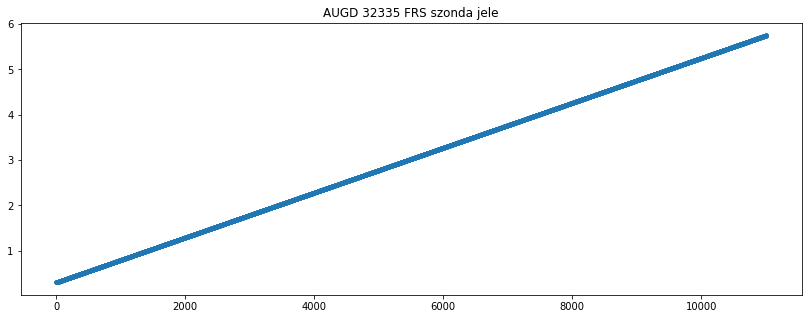


 AUGD 32335 FRS


In [34]:
#%%script false
plt.figure(figsize=(14,5))
plt.title(shot+' szonda jele')
plt.plot(x,'.-')
#yaxismax=1/2**(view.value/12)
#plt.xlim(min(x),max(x)-(max(x)-min(x))*((view/100.4)**0.6))
#plt.ylabel('radiális mágneses tér változás (T/s)')
#plt.xlabel('idő (s)')
#plt.savefig(shot+' in.pdf')
plt.show()

print("\n",shot)

The script provided at   *augtwiki/bin/view/Reflectometry/Read*   to load reflectometries

(4548, 100)
(4548, 100)


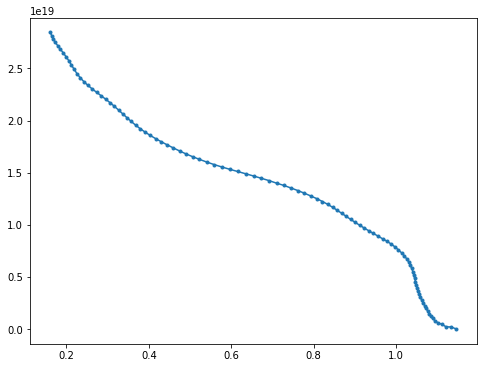

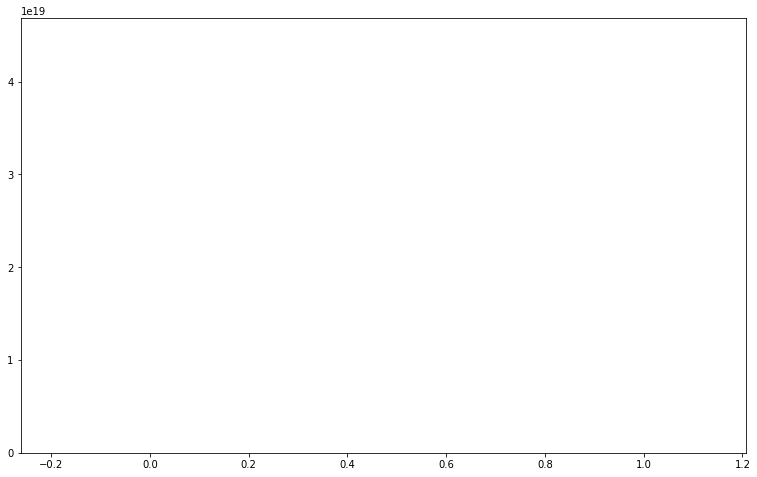

In [7]:
##Read the data
print(rho.shape)
print(ne.shape)

plt.figure(figsize=(8,6))
plt.plot(rho[2],ne[2],'.-')#.data[1000,:]
#plt.title('%s @ t=%3.2fs'%(nl.description, time[1000]))
#plt.ylabel(nl.unit)
#plt.xlabel('R [%s]' %(rl.units))
plt.show()

fig = plt.figure(figsize=(13,8))
ax = plt.axes(xlim=(np.min(rho), np.max(rho)), ylim=(np.min(ne), np.max(ne)))
line, = plt.plot([], [], lw=3)

def init():
    line.set_data([], [])
    return line,
def animate(i):
    line.set_data(rho[i],ne[i])
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=400, interval=100, repeat_delay=1000, repeat=True, blit=True)

# anim.save('FRS_profiles.gif', writer='imagemagick')
#https://www.wikihow.com/Install-FFmpeg-on-Windows
#https://stackoverflow.com/questions/20137792/using-ffmpeg-and-ipython

In [12]:
from matplotlib.animation import FFMpegWriter
writer = FFMpegWriter(fps=15, metadata=dict(artist='Me'), bitrate=1800)
anim.save("FRS1.mp4", writer=writer)

In [13]:
HTML(anim.to_html5_video())

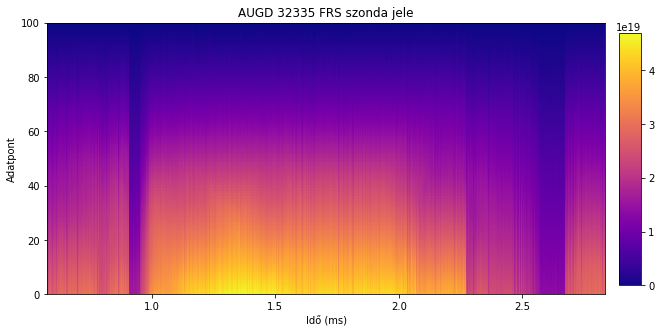

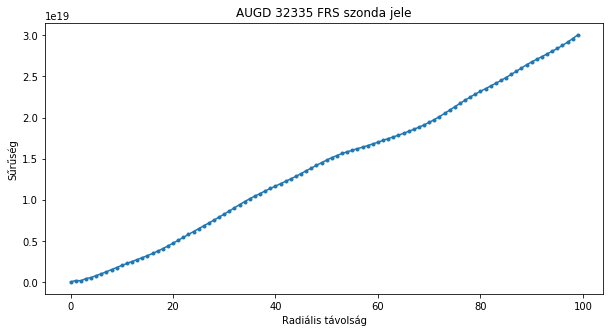

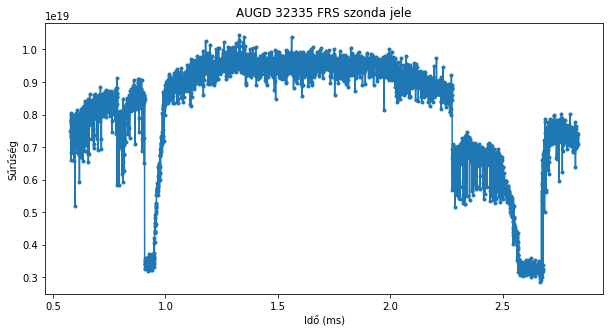

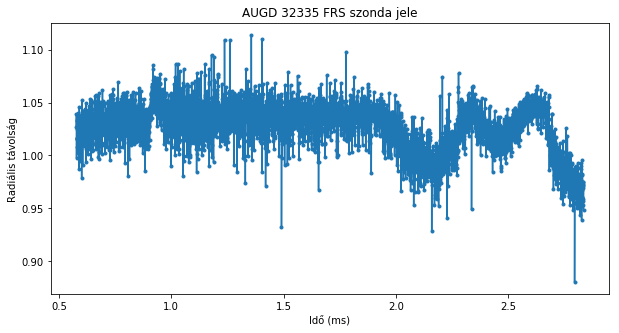

In [8]:
#ne2=np.transpose(ne)
plt.figure(figsize=(10,5))
plt.imshow(ne.T,aspect='auto',cmap='plasma', extent=[min(x),max(x),0,100])
plt.title(shot+' szonda jele')
plt.xlabel('Idő (ms)')
plt.ylabel('Adatpont')
cax = plt.axes([0.92, 0.15, 0.03, 0.7])
plt.colorbar(cax=cax).set_label('')
#plt.subplots_adjust(right=0.95)
#plt.savefig(shot+' fullprofile.pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ne[200,:],'.-')
plt.title(shot+' szonda jele')
plt.ylabel('Sűrűség')
plt.xlabel('Radiális távolság')
#plt.savefig(shot+' profile 200.pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(x,ne[:,30],'.-')
plt.title(shot+' szonda jele')
plt.xlabel('Idő (ms)')
plt.ylabel('Sűrűség')
#plt.savefig(shot+' at freq 30.pdf')
plt.show()

plt.figure(figsize=(10,5))
plt.plot(x,rho[:,30],'.-')
plt.title(shot+' szonda jele')
plt.xlabel('Idő (ms)')
plt.ylabel('Radiális távolság')
#plt.savefig(shot+' at freq 30.pdf')
plt.show()

## Short-time Fourier transform

We slice the signal up, then from each slice, we substract its average and multiply it with a gaussian window.

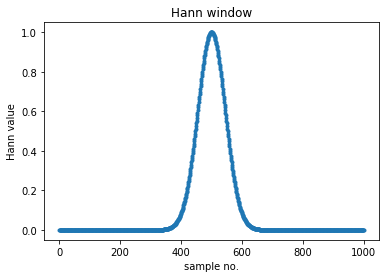

In [20]:
win_r = 500 #1000
d_win=5#random.randint(200,300)
std=45 #150
win_base = scipy.signal.gaussian(2*win_r+1, std=std)#np.wining(2*win_r+1)

plt.plot(win_base,".-")
plt.title('Hann window')
plt.xlabel('sample no.')
plt.ylabel('Hann value')
plt.show()

In [21]:
target_rho = 0.8
s = np.zeros(samples)

#interpolation (selecting ne-s with the closest rho)
for i in range(samples):
    got_h=0
    for j in range(channels):
        if got_h == 0:
            if rho[i,j] < target_rho:
                s[i]=ne[i,j]
                got_h=1
    if got_h == 0:
        s[i]= float('nan')

s_plain = copy.deepcopy(s)

In [23]:
#interpolation of NaN data from existing signal points
for i in range(samples):
    if math.isnan(s[i]):
        j = i
        find_u = 0
        find_d = 0
        while 

In [24]:
%%script false
#extrapolation of NaN data from end of profile
fit_i = 0
for i in range(samples):
    if math.isnan(s[i]):
        if target_rho > rho[i,0]:
            fit = np.polyfit(rho[i,0:2],ne[i,0:2],2)
            fit_i = i
        if target_rho < rho[i,-1]:
            fit = np.polyfit(rho[i,-4:-1],ne[i,-4:-1],1)
            fit_i = i
        p = np.poly1d(fit)
        s[i] = p(target_rho)

print(s_plain)
print(s)

p = np.poly1d(fit)
xp = np.linspace(0, 1, 100)

plt.figure(figsize=(8,6))
plt.plot(rho[fit_i],ne[fit_i],'.-',xp,p(xp),'--')
#plt.title('%s @ t=%3.2fs'%(nl.description, time[1000]))
#plt.ylabel(nl.unit)
#plt.xlabel('R [%s]' %(rl.units))
plt.show()
print(fit_i)

Couldn't find program: 'false'


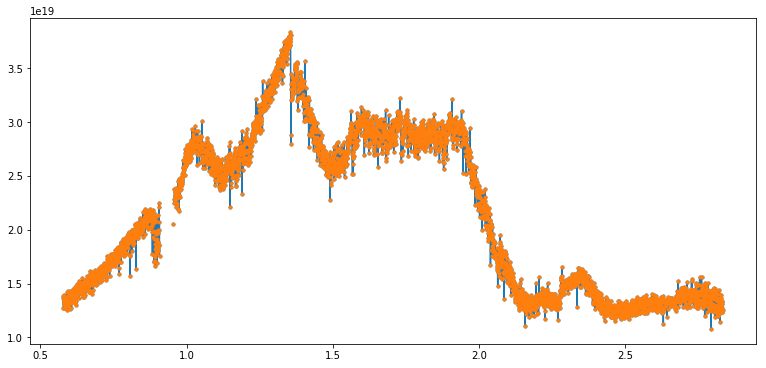

4235


In [22]:
plt.figure(figsize=(13,6))
plt.plot(x,s,'.-',x,s_plain,'.')
plt.title('')
#plt.ylabel(nl.unit)
#plt.xlabel('R [%s]' %(rl.units))
plt.show()
print(fit_i)

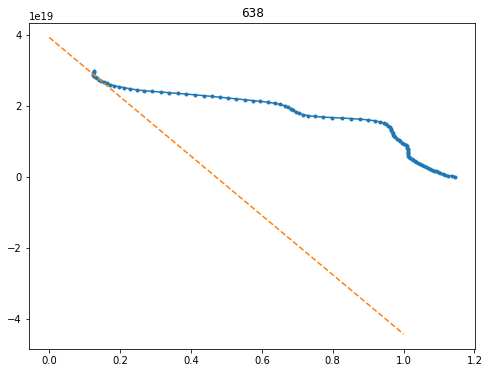

In [114]:
n = 0
for i in range(samples):
    if s[i]<= 0:
        fit = np.polyfit(rho[i,-10:-1],ne[i,-10:-1],1)
        p = np.poly1d(fit)
        s[i]=p(target_rho)
        if  n < 5:
            xp = np.linspace(0, 1, 100)
            plt.figure(figsize=(8,6))
            plt.plot(rho[i],ne[i],'.-',xp,p(xp),'--')
            plt.title(i)
            plt.show()
            n += 1

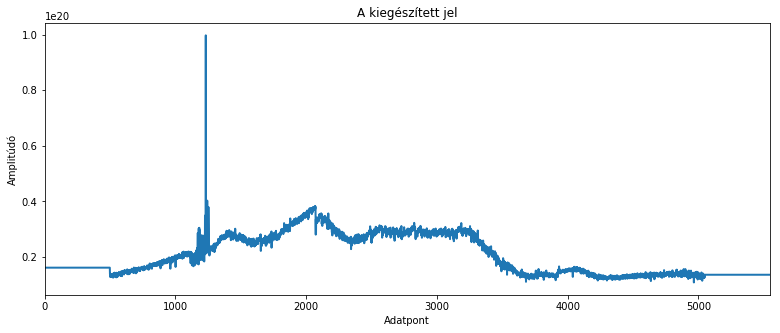

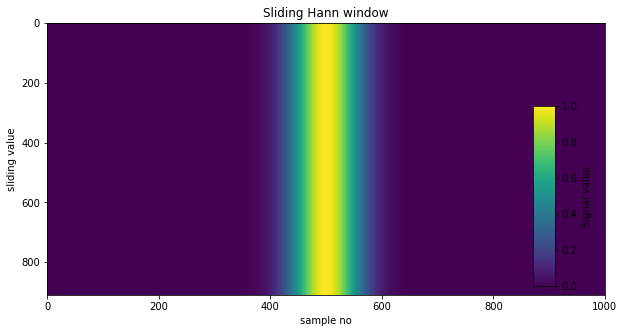

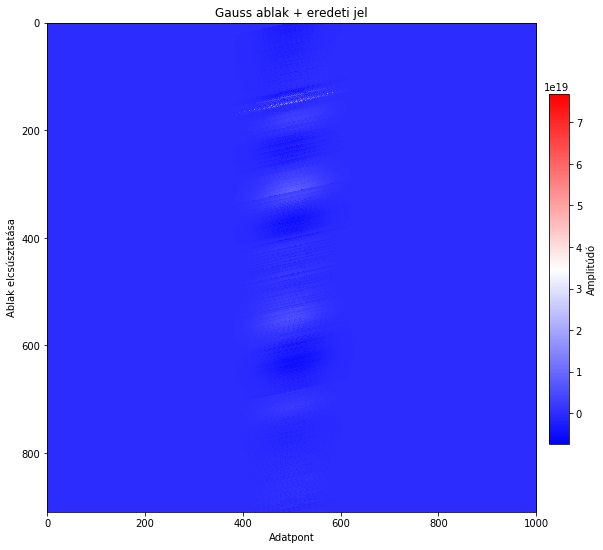

4.714215916868019e+31
4.703513723308402e+41
45
(910, 501)
(501, 910)


In [16]:
z_padded_s = np.zeros (samples+2*win_r)
z_padded_s[win_r:-win_r] = s
z_padded_s[0:win_r]=np.average(z_padded_s[win_r+1:2*win_r])
z_padded_s[-win_r:]=np.average(z_padded_s[-2*win_r:-win_r-1])
x_win=np.linspace(0.0, t+(2*win_r/s_rate), samples+2*win_r)

plt.figure(figsize=(13,5))
plt.plot(z_padded_s,"-",linewidth = 2)#x_win,idő (s),max(x_win)
plt.xlim((0,samples+2*win_r))
plt.title('A kiegészített jel')
plt.xlabel('Adatpont')
plt.ylabel('Amplitúdó')
plt.savefig('sxr2_p.pdf')
plt.show()


win = np.zeros((int(samples/d_win+1), 2*win_r+1))
for i in range(int(samples/d_win+1)):
    win [i]=win_base

plt.figure(figsize=(10,5))
plt.imshow(win,aspect='auto')
plt.title('Sliding Hann window')
plt.xlabel('sample no')
plt.ylabel('sliding value')
#plt.subplots_adjust(right=0.95)
cax = plt.axes([0.8, 0.15, 0.03, 0.5])
plt.colorbar(cax=cax).set_label('Signal value')
plt.show()

z_win = np.zeros((int(samples/d_win+0.9), win_r*2+1))
for i in range(int(samples/d_win+0.9)):
    z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1]-np.average(z_padded_s [d_win*i:d_win*i+win_r+win_r+1]))
    #z_win[i] = win[i] * (z_padded_s [d_win*i:d_win*i+win_r+win_r+1])

plt.figure(figsize=(9,9))
plt.imshow(z_win,aspect='auto',cmap='bwr')#, extent=(min(x)*s_rate/d_win,max(x)*s_rate/d_win,max(x)*s_rate,min(x)*s_rate)
plt.title('Gauss ablak + eredeti jel')
plt.xlabel('Adatpont')
plt.ylabel('Ablak elcsúsztatása')
plt.subplots_adjust(right=0.88)
cax = plt.axes([0.90, 0.23, 0.03, 0.54])
plt.colorbar(cax=cax).set_label('Amplitúdó')
plt.savefig('z_win.pdf')
plt.show()

z_win_fft = np.zeros((int(samples/d_win+0.9), win_r+1))
for i in range(int(samples/d_win+0.9)):
    z_win_fft[i] = np.abs(scipy.fftpack.fft(z_win[i]))[:win_r+1]  
t1=time.time()

print(z_win_fft.min()**2)
print(z_win_fft.max()**2)
print(std)

z_win_fft_sq = (z_win_fft.T)**2
print(z_win_fft.shape)
print(z_win_fft_sq.shape)

We can display the calculated STFT.

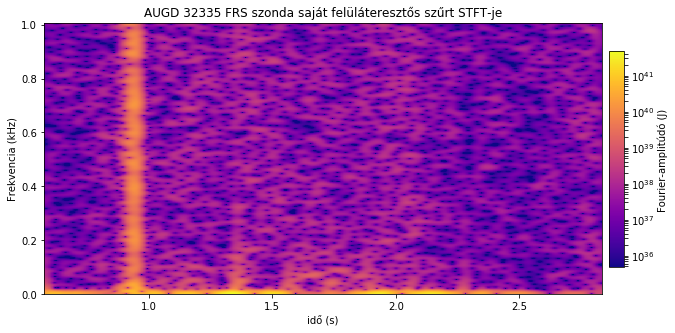

In [17]:
##### %%script false
colornorm=colors.LogNorm(vmin=z_win_fft_sq.min()*10000, vmax=z_win_fft_sq.max()/1)
logax = np.linspace(int(np.log10(z_win_fft_sq.min())),int(np.log10(z_win_fft_sq.max())),int(np.log10(z_win_fft_sq.max()))-int(np.log10(z_win_fft_sq.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(10,5))
#extent=[0,t-(2*hann_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
#ax.plot(x,np.abs(full_f),color='g',linewidth=3,linestyle='dashed',alpha=0.6)#img = ax.
img = plt.imshow(z_win_fft_sq,cmap='plasma',  aspect='auto', extent=[min(x),max(x),frangemax/1000,0], norm=colornorm)#interpolation='gaussian',*30000000/4
plt.title(shot+' szonda saját felüláteresztős szűrt STFT-je')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
#plt.xlim(0.642,0.658)
#plt.ylim(90,30)
plt.subplots_adjust(right=0.90)
plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-amplitúdó (J)')
#plt.axis([2.13,2.15,min(s),20000])
#cbar.set_ticks(logax)
#plt.savefig(shot+' stft.pdf')#34924_40
plt.show()

In [18]:
#%%script false
#ridge_no = 1
print(samples/d_win)

print(s_rate-0.9)
print(nyquist/((2*win_r+1)/s_rate-0.9))
ridge_d=2000#50#
ridge_d2=800
ridge_start=4000#2#
ridge = np.zeros(int(samples/d_win+0.9))
ridge_h = np.zeros(int(samples/d_win+0.9))
maxi=z_win_fft.max()/40
print(maxi)

for i in range(int(samples/d_win+0.9)):
    ridgeval=0  #max(z_spy_stft[i][:])
    if (i==0) or (ridge[i-1]==0):
        for j in range(int(ridge_d*(2*win_r+1)/(s_rate-0.9))):
            j2=j+int((ridge_start)*(2*win_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
    else:
        for j in range(int(ridge_d2*(2*win_r+1)/(s_rate-0.9))):
            j2=int(j+ridge[i-1]-(ridge_d2/2)*(2*win_r+1)/(s_rate-0.9))
            if ridgeval < z_win_fft[i][j2]:
                ridgeval=z_win_fft[i][j2]
                ridge[i]= j2
                #print(j2, z_spy_stft[j2][i])
    if ridgeval<(maxi):
        ridgeval =0
        ridge [i]=0
    ridge_h[i]=ridgeval**(1/2)
    #print(i, ridge [i])
    #print (i,"  ",ridge[i],"\t", ridgeval,"\t", z_spy_stft[i][int(ridge[i])])

ridge=ridge*(s_rate/(2*win_r+1))

#proc_x=np.linspace(min(x),max(x),np.size(ridge))
ridge[ ridge==0 ] = np.nan
plt.figure(figsize=(14,3.5))
plt.title(shot+' szonda maximum frekvenciaértékei')
plt.plot(np.linspace(min(x),max(x),np.size(ridge)),ridge/1000,'.-')
plt.grid(True)
#plt.legend(('Kiszámolt', 'Eredeti'))
#yaxismax=1/2**(view.value/12)
plt.xlim(min(x),max(x))
#plt.ylim(ridge_start/1100,)
#plt.ylim(0,200)
#plt.xlim(0.89,0.91)
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')
#plt.savefig(shot+' f_max.pdf')
plt.show()

909.6
2014.4275628744117
-2498.5058668966303
1.7145541919308796e+19


IndexError: index 1987 is out of bounds for axis 0 with size 501

In [ ]:
logax = np.linspace(int(np.log10(z_win_fft_sq.min())),int(np.log10(z_win_fft_sq.max())),int(np.log10(z_win_fft_sq.max()))-int(np.log10(z_win_fft_sq.min()))+1)
logax = 10**logax
fig, ax = plt.subplots(figsize=(14,5))
#extent=[0,t-(2*hann_r/s_rate),0,frangemax/t],
#plt.figure(figsize=(15,10))
ax.plot(np.linspace(min(x),max(x),np.size(ridge)),ridge/1000,'.',color='g',alpha=0.6)#,linewidth=3,linestyle='dashed')#img = ax.
img = plt.imshow(z_win_fft_sq,cmap='plasma', interpolation='gaussian', aspect='auto', extent=[min(x),max(x),frangemax/1000,0], norm=colornorm)#
#plt.title('My Short-time Fourier transform')
plt.title(shot+'-es szonda STFT-je, adaptív maximumkereséssel')
plt.ylabel('Frekvencia (kHz)')
plt.xlabel('idő (s)')#('time (s)')
#plt.xlim(0.652,0.66)
#plt.ylim(90,40)
plt.subplots_adjust(right=0.90)
plt.gca().invert_yaxis()
cbar=plt.colorbar(img,cax=plt.axes([0.91, 0.2, 0.02, 0.6]),ticks=None)
cbar.set_label('Fourier-érték (J)')
#plt.axis([2.13,2.15,min(s),20000])
cbar.set_ticks(logax)
#plt.savefig(shot+' stft_max.pdf')
plt.show()

In [ ]:
ridge_h[ ridge_h==0 ] = np.nan
print(maxi**(1/2))
plt.figure(figsize=(10,3.5))
plt.title('Az amplitúdó a maximum frekvenciaértékeknél, '+shot)#, AUGD 34924 J051-es szonda
plt.plot(np.linspace(min(x),max(x),np.size(ridge_h)),ridge_h,'-',markersize=1)#,x,3*abs(np.sin(2*np.pi*x))+2,
plt.grid(True)
plt.xlim(min(x),max(x))
#plt.xlim(0.89,0.91)
#plt.ylim(maxi**(1/2)/2,max(ridge_h)*1.05)
plt.ylabel('Amplitúdó')
plt.xlabel('idő (s)')
#plt.yscale("log")
#plt.savefig(shot+'_amp.pdf')
plt.show()